In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(gtools)

# entropy calculation only among those genes undergoing an isoform switch
# entropy measures the homogeneity in the distribution of the patients 
# in different cancer types
shannon.entropy <- function(p){
  if (invalid(p) || min(p) < 0 || sum(p) <= 0)
    return(NaN)
  p.norm <- p[p>0]/sum(p)
  H <- -sum(log2(p.norm)*p.norm)
  if (H == 0){
    0
  } else {
    maxH <- log2(length(p.norm))
    H/maxH
  }
}

get.entropy <- function(genes,ntxs,ttxs,patients,mask){
    m <- ifelse(is.null(mask),FALSE,mask)
    switches.agg <- data.frame(Gene=genes,nTx=ntxs,tTx=ttxs,Patients=patients) %>%
        filter(m) %>%
        group_by(Gene,nTx,tTx) %>%
        summarise(Patients=sum(Patients)) %>%
        mutate(p=Patients/sum(Patients))
    shannon.entropy(switches.agg$p)
}

get.uniq.switches <- function(genes,ntxs,ttxs,mask){
    m <- ifelse(is.null(mask),FALSE,mask)
    as.data.frame(cbind(genes,ntxs,ttxs)) %>%
        filter(m) %>%
        unique %>%
        nrow
}

get.uniq.patients <- function(genes,ntxs,ttxs,patients,mask){
    m <- ifelse(is.null(mask),FALSE,mask)
    switches <- data.frame(Gene=genes,nTx=ntxs,tTx=ttxs,Patients=patients) %>%
        filter(m)
    sum(switches$Patients)
}

my.binomial.test <- function(x,testNumber){ 
    if (!is.na(x[1]) & ! is.na(x[2]))
        binom.test(x[1],testNumber,x[2],"greater")$p.value
    else
        NA
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Read switches
switches <- read_tsv("../data/pancancer/candidateList_info.tumorSplit.tsv")

# Read feature information
features <- read_tsv("../data/mutations/proteome_features.txt") %>%
    filter(Analysis == "Pfam")

# Read information of the expressed transcripts (TPM>=0.1)
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    mutate(asEvidence=as.numeric(revalue(asEvidence,c("True"="1","False"="0"))))

# Get statistics per feature
pfam.agg <- features %>%
    # consider splicing information for frequency calculation
    merge(proteome) %>%
    # count at feature level
    group_by(Feature) %>%
    summarize(ProteomeCounts=length(Feature)-sum(!asEvidence),  ## remove cases where no as evidence was found
              TotalLength = sum(FeatureLength)) %>% ## for mutations we apply no filter
    # get expected frequencies
    mutate(ExpectedSwitchFrequency = ProteomeCounts/sum(ProteomeCounts), 
           ExpectedMutFrequency = TotalLength/sum(TotalLength))

# Read structural changes
switches.pfam <- read_tsv('../data/structural_analysis/structural_features.onlyModels.tsv') %>%
    filter(Random=="NonRandom" & Analysis=="Pfam" & WhatsHappenning!="Nothing") %>%
    # Use switch information to characterize structural information
    merge(switches,by.x=c("Cancer","Gene","Symbol","nTx","tTx"),
          by.y=c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript"))

## Calculate enrichment in switches

In [3]:
pfam.switch_info <- switches.pfam %>%
    group_by(Feature) %>%
    summarize(LostNum = sum((WhatsHappenning=="Lost_in_tumor") * PatientNumber), 
              GainNum = sum((WhatsHappenning=="Gained_in_tumor") * PatientNumber), 
              H_g = get.entropy(Gene,nTx,tTx,PatientNumber,WhatsHappenning=="Gained_in_tumor"), 
              H_l = get.entropy(Gene,nTx,tTx,PatientNumber,WhatsHappenning=="Lost_in_tumor"), 
              patients_g = get.uniq.patients(Gene,nTx,tTx,PatientNumber,WhatsHappenning=="Gained_in_tumor"),
              switches_g = get.uniq.switches(Gene,nTx,tTx,WhatsHappenning=="Gained_in_tumor"),
              patients_l = get.uniq.patients(Gene,nTx,tTx,PatientNumber,WhatsHappenning=="Lost_in_tumor"),
              switches_l = get.uniq.switches(Gene,nTx,tTx,WhatsHappenning=="Lost_in_tumor"))

# aggregate switches
totalGains <- sum(pfam.switch_info$GainNum)
totalLosses <- sum(pfam.switch_info$LostNum)

# calculate statistics
pf <- merge(pfam.agg,pfam.switch_info,all=T) %>%
    mutate(fc_g = GainNum/totalGains/ExpectedSwitchFrequency,
           fc_l = LostNum/totalLosses/ExpectedSwitchFrequency) %>%
    mutate(., 
           p_g = apply(subset(.,select=c("GainNum","ExpectedSwitchFrequency")),1,my.binomial.test,totalGains),
           p_l = apply(subset(.,select=c("LostNum","ExpectedSwitchFrequency")),1,my.binomial.test,totalLosses)) %>%
    mutate(adjp_g = p.adjust(p_g),
           adjp_l = p.adjust(p_l)) %>%
    mutate(Name = gsub("|","@",Feature,fixed = T)) %>%
    mutate(Name = gsub("_"," ",Name,fixed = T)) %>%
    mutate(id = unlist(strsplit(Name,"@"))[c(T,F)], 
           Name = unlist(strsplit(Name,"@"))[c(F,T)])

Let's check the domains that are significantly enriched in switches and that affect more than one switch. The rationale behind the latter criteria is that if a domain is only affected by one switch, we have no-way to ensure it is domain specific rather than gene-specific.

In [4]:
sum(pf$adjp_l<0.05 & pf$switches_l>1,na.rm=T)
sum(pf$adjp_g<0.05 & pf$switches_g>1,na.rm=T)

[1] 341

[1] 70

## Description of the domains

In [5]:
# plot number of domains in each condition
df <- pf

df$Tag <- "Not altered"
df$Tag[df$adjp_g < 0.05 & pf$switches_g>1] <- "Gained"
df$Tag[df$adjp_l < 0.05 & pf$switches_l>1] <- "Lost"
df$Tag[df$adjp_g < 0.05  & pf$switches_g>1 & df$adjp_l < 0.05 & pf$switches_l>1] <- "Both"

table(df$Tag)


     Gained        Lost Not altered 
         70         341        4896 

### Comparison to mutations

In [6]:
# Read mutations
allMuts <- c("Frame_Shift_Del","Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins","Missense_Mutation",
             "Nonsense_Mutation","Nonstop_Mutation","Frame_Shift_Del_out","Frame_Shift_Ins_out",
             "Nonsense_Mutation_out")
inFeatureMuts <- c("Frame_Shift_Del","Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins",
                   "Missense_Mutation","Nonsense_Mutation","Nonstop_Mutation")

## calculate total mutations per domain
proteome.muts <- read_tsv("../data/mutations/proteome_mutations.txt") %>%
    filter(Analysis=="Pfam") %>%
    # convert from long format to wide format
    dcast(formula=Feature+Cancer+Transcript~Type, value.var="Patient",fun.aggregate=length) %>%
    group_by(Feature) %>%
    summarise(Frame_Shift_Del = sum(Frame_Shift_Del),
              Frame_Shift_Ins = sum(Frame_Shift_Ins),
              In_Frame_Del = sum(In_Frame_Del),
              In_Frame_Ins = sum(In_Frame_Ins),
              Missense_Mutation = sum(Missense_Mutation),
              Nonsense_Mutation = sum(Nonsense_Mutation),
              Nonstop_Mutation = sum(Nonstop_Mutation),
              Frame_Shift_Del_out = sum(Frame_Shift_Del_out),
              Frame_Shift_Ins_out = sum(Frame_Shift_Ins_out),
              Nonsense_Mutation_out = sum(Nonsense_Mutation_out)) %>%
    mutate(TotalMutations = rowSums(.[,inFeatureMuts]))

# enrichment test
pf.m <- merge(pfam.agg,proteome.muts) %>%
    mutate(fc_m = TotalMutations/sum(TotalMutations)/ExpectedMutFrequency,
           p_m = apply(.[,c("TotalMutations","ExpectedMutFrequency")],1, my.binomial.test, sum(TotalMutations)),
           adjp_m = p.adjust(p_m))

# create table with all the analysis
pf.all <- merge(pf,pf.m,all=T)

# save results
subset(pf.all,select=c("id","Feature","ProteomeCounts","ExpectedSwitchFrequency","LostNum","GainNum",
                   "fc_g","fc_l","fc_m","p_g","adjp_g","p_l","adjp_l","p_m","adjp_m","H_g","H_l",
                   "switches_g","switches_l","patients_g","patients_l")) %>%
    write_tsv("../results/pfam_enrichment_analysis.tsv")

In [7]:
sum(pf.m$adjp_m < 0.05)

[1] 77

In [8]:
M <- pf.all$adjp_m < 0.05
M[is.na(M)] <- FALSE
S <- (pf.all$adjp_l < 0.05 & pf.all$switches_l > 1) | (pf.all$adjp_g < 0.05 & pf.all$switches_g > 1)
S[is.na(S)] <- FALSE

l <- rep("N", nrow(pf.all))
l[M] <- "M"
l[S] <- "S"
l[M&S] <- "MS"

m <- matrix(table(l),2,2)
fisher.test(m)
m %>%
    as.data.frame %>%
    set_colnames(c("M","NM")) %>%
    set_rownames(c("NS","S"))


	Fisher's Exact Test for Count Data

data:  m
p-value = 0.0006782
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1882892 0.6472163
sample estimates:
odds ratio 
 0.3387039 


,M,NM
NS,62,4834
S,15,396


There is a higher coincidence than expected by chance. Hence, switches and mutations seem to affect the same protein domains.

In [9]:
# display MS domains
pf.all$Feature[M&S] %>%
    gsub("_"," ",.) %>%
    gsub("PF[0-9]+\\|","",.) %>%
    cbind(pf.all$id[M&S],.) %>%
    set_colnames(c("Id","Name"))

Id,Name
PF00041,Fibronectin type III domain
PF00090,Thrombospondin type 1 domain
PF00413,Matrixin
PF00535,Glycosyl transferase family 2
PF00683,TB domain
PF00969,"Class II histocompatibility antigen, beta domain"
PF01421,Reprolysin (M12B) family zinc metalloprotease
PF01833,IPT/TIG domain
PF02931,Neurotransmitter-gated ion-channel ligand binding domain
PF07645,Calcium-binding EGF domain


In [10]:
# genes where MS domains change
features %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    merge(switches,by.x=c("Gene","Symbol"),by.y=c("GeneId","Symbol")) %>%
    arrange(desc(PatientNumber)) %>%
    select(Gene,Symbol,PatientNumber) %>%
    unique %>%
    head(n=15)

,Gene,Symbol,PatientNumber
1,2199,FBLN2,343
62,2199,FBLN2,247
123,345193,LRIT3,134
128,51162,EGFL7,129
139,3671,ISLR,119
150,3371,TNC,115
282,56253,CRTAM,93
285,4915,NTRK2,72
307,63917,GALNT11,67
318,1525,CXADR,66


In [11]:
# total number of domains observed
length(unique(c(pfam.agg$Feature,pf$Feature,pf.m$Feature)))

# number of domains for which switch has been observed
sum(pf$LostNum > 0 | pf$GainNum > 0,na.rm=T)

# number of domains for which a mutation has been observed
sum(pf.m$TotalMutations > 0)

[1] 5307

[1] 1776

[1] 5054

### GO term enrichment

### Comparison M - S

In [12]:
# Read pfam annotation
pfam2go <- read_tsv("~/smartas/data/PFAM2GO.txt",skip=1)
go.levels <- read_tsv("../data/PFAMGO.txt",skip=1)

pfam2go.m <- merge(pfam2go,go.levels) 

# Get list of all observed domains with their associated annotation
domains <- dlply(pfam2go.m,.(slim_level,GO_subontology,GO_ID),function(x){
    intersect(pf$id,unlist(strsplit(x[,3],",")))
}) %>% unlist 
class <- gsub("\\.[^\\.]+$","",names(domains))

expressedgos <- unlist(strsplit(names(domains),".",fixed=T))[c(F,F,T)] %>% 
    substr(1,10) %>%
    split(class) %>%
    lapply(unique)

In [13]:
# read GO term enrichment analysis and calculate an agreement between M and S
## molecular function
smf <- read_tsv("../results/pfam_go_term/S_GO_molecular_function.tsv",skip=15)
mmf <- read_tsv("../results/pfam_go_term/M_GO_molecular_function.tsv",skip=15)

x <- table(rbind(mmf[,c(2,4)],smf[,c(2,4)]))
c.mf <- colSums(x==2)
a.mf <- colSums(x>0)
s.mf <- colSums(table(smf[,c(2,4)]))
m.mf <- colSums(table(mmf[,c(2,4)]))

## cellular component
scc <- read_tsv("../results/pfam_go_term/S_GO_cellular_component.tsv",skip=15)
mcc <- read_tsv("../results/pfam_go_term/M_GO_cellular_component.tsv",skip=15)

x <- table(rbind(mcc[,c(2,4)],scc[,c(2,4)]))
c.cc <- colSums(x==2)
a.cc <- colSums(x>0)
s.cc <- colSums(table(scc[,c(2,4)]))
m.cc <- colSums(table(mcc[,c(2,4)]))

## biological process
sbp <- read_tsv("../results/pfam_go_term/S_GO_biological_process.tsv",skip=15)
mbp <- read_tsv("../results/pfam_go_term/M_GO_biological_process.tsv",skip=15)

x <- table(rbind(mbp[,c(2,4)],sbp[,c(2,4)]))
c.bp <- colSums(x==2)
a.bp <- colSums(x>0)
s.bp <- colSums(table(sbp[,c(2,4)]))
m.bp <- colSums(table(mbp[,c(2,4)]))

# aggregate data
coincidence <- data_frame(Match=c(c.mf,c.cc,c.bp),
                          Any=c(a.mf,a.cc,a.bp),
                          M=c(m.mf,m.cc,m.bp),
                          S=c(s.mf,s.cc,s.bp),
                          GO_subontology=c(rep('molecular_function',4),
                                           rep('cellular_component',4),
                                           rep('biological_process',4)),
                          slim_level=rep(
                              c('Least Informative','Moderately Informative','Informative','Highly Informative'),3)) %>%
    mutate(MatchPerc=100*Match/Any, Coincidence="Observed", sd=NA, sdPerc=NA,
           slim_level=factor(slim_level,levels=
                             c('Least Informative','Moderately Informative','Informative','Highly Informative')))


Warning message:
: Removed 12 rows containing missing values (geom_errorbar).

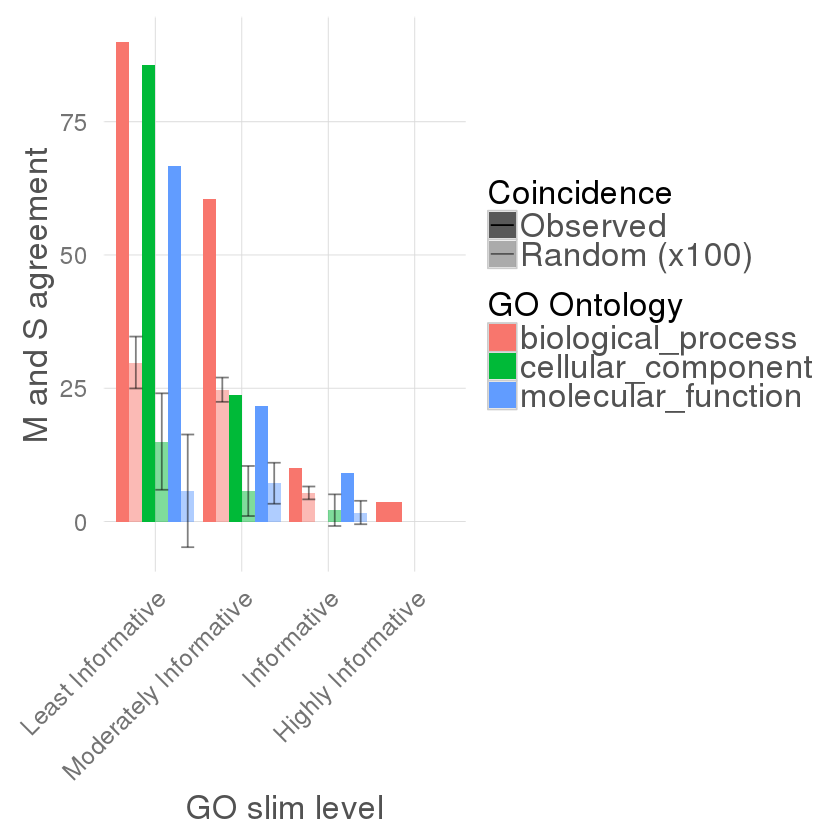

In [14]:
# prepare df to get number of samples
M <- unique(coincidence[,c('GO_subontology','slim_level',"M","S")])
rand <- list()
for (c in names(expressedgos)){
    # select real data comparison
    v <- paste(M$slim_level,M$GO_subontology,sep=".")==c
    if (sum(v)==0) next
    x <- M[v,]
    tmp <- list()
    # permutate 100 times
    for (i in 1:100){
        m <- sample(expressedgos[[c]],x$M)
        s <- sample(expressedgos[[c]],x$S)
        tmp[[i]] <- length(intersect(m,s))/length(unique(c(m,s)))
    }
    tmp <- do.call("rbind",tmp)
    rand[[c]] <- data.frame(slim_level=x$slim_level,GO_subontology=x$GO_subontology,Match=mean(tmp),sd=sd(tmp))
}
    
rand <- do.call("rbind",rand)

#join random data and real data and plot
rand %>%
    mutate(MatchPerc=Match*100, sdPerc=sd*100, Coincidence="Random (x100)") %>%
    rbind(subset(coincidence,select=c("GO_subontology","slim_level","Match","sd","MatchPerc","sdPerc","Coincidence"))) %>%
    mutate(slim_level=factor(slim_level,levels=
                            c('Least Informative','Moderately Informative','Informative','Highly Informative')))  %>%
    ggplot(aes(fill=GO_subontology,y=MatchPerc,x=slim_level,alpha=Coincidence)) +
        geom_bar(position="dodge",stat="identity") +
        geom_errorbar(aes(ymax=MatchPerc+sdPerc,ymin=MatchPerc-sdPerc),position="dodge") +
        scale_alpha_discrete(range=c("Observed"=1,"Random (x100)"=0.5)) +
        labs(x="GO slim level",y="M and S agreement",fill="GO Ontology") +
        smartas_theme() +
        theme(legend.position="right",axis.text.x = element_text(angle=45, hjust=1))

In [15]:
# some molecular function terms
x <- table(rbind(mmf[,c(3,4)],smf[,c(3,4)]))
rownames(x)[x[,1]==2]
rownames(x)[x[,2]==2]
rownames(x)[x[,3]==2]

[1] "molecular transducer activity" "receptor activity"

[1] "calcium ion binding"                           
[2] "cargo receptor activity"                       
[3] "cell adhesion molecule binding"                
[4] "protein complex binding"                       
[5] "protein domain specific binding"               
[6] "protein tyrosine kinase activity"              
[7] "receptor binding"                              
[8] "transmembrane receptor protein kinase activity"

[1] "collagen binding"                     
[2] "PDZ domain binding"                   
[3] "phosphatidylinositol 3-kinase binding"

## Coincidence in genes
We will check if the domains affected by mutations and switches tend to co-occurr in the same genes.

In [16]:
M <- pf.all$adjp_m < 0.05
M[is.na(M)] <- FALSE
S <- (pf.all$adjp_l < 0.05 & pf.all$switches_l > 1) | (pf.all$adjp_g < 0.05 & pf.all$switches_g > 1)
S[is.na(S)] <- FALSE

# get the genes with a switch involving a MS domain
s.genes <- switches.pfam %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(Gene,Symbol,Feature) %>%
    unique %>%
    mutate(Switched=TRUE)

# get the genes with a mutation involving a MS domain
m.genes <- read_tsv("../data/mutations/proteome_mutations.txt") %>%
    filter(Analysis=="Pfam") %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(Gene,Symbol,Feature) %>%
    unique %>%
    mutate(Mutated=TRUE)

# check all genes containing this feature in the proteome
all.genes <- features %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(Gene,Symbol,Feature) %>%
    unique

# merge to see coincidence between genes
x <- merge(s.genes,m.genes,all=T) %>%
    merge(all.genes,all=T) %>%
    mutate(Switched=ifelse(is.na(Switched),FALSE,TRUE),
           Mutated=ifelse(is.na(Mutated),FALSE,TRUE)) %>%
    group_by(Feature) %>%
    summarise(MS=sum(Mutated&Switched), M=sum(Mutated), 
              S=sum(Switched), N=length(Gene)) %>%
    mutate(M=M-MS, S=S-MS, 
           N=N-(MS+S+M), J=MS/(M+S+MS)) %>%
    arrange(desc(J))

x

,Feature,MS,M,S,N,J
1,PF00683|TB_domain,5,2,0,0,0.7142857
2,PF15440|THRAP3/BCLAF1_family,2,1,0,0,0.6666667
3,"PF00969|Class_II_histocompatibility_antigen,_beta_domain",3,2,1,2,0.5
4,PF10409|C2_domain_of_PTEN_tumour-suppressor_protein,2,4,0,1,0.3333333
5,PF01833|IPT/TIG_domain,7,15,1,0,0.3043478
6,PF07679|Immunoglobulin_I-set_domain,37,93,7,7,0.270073
7,PF00041|Fibronectin_type_III_domain,33,86,5,7,0.266129
8,PF07645|Calcium-binding_EGF_domain,17,52,1,1,0.2428571
9,PF00090|Thrombospondin_type_1_domain,11,36,3,5,0.22
10,PF00535|Glycosyl_transferase_family_2,5,18,0,1,0.2173913


In [18]:
switches.pfam %>%
    filter(Feature=="PF00683|TB_domain") %>%
    select(Gene,Symbol,WhatsHappenning) %>%
    unique

,Gene,Symbol,WhatsHappenning
1,4052,LTBP1,Lost_in_tumor
3,4054,LTBP3,Lost_in_tumor
18,8425,LTBP4,Lost_in_tumor
20,2200,FBN1,Lost_in_tumor
45,2201,FBN2,Lost_in_tumor
